In [0]:
import numpy as np
import cv2 
import os
import glob
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras import losses, metrics, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.transform import resize, rescale
from skimage.io import imread
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from sklearn.utils import class_weight
%matplotlib inline

In [4]:
#mount the gdrive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#load the dataset
with open('gdrive/My Drive/dataset_isic_256/X_clf', 'rb') as f:
  X = pickle.load(f)
  
with open('gdrive/My Drive/dataset_isic_256/X_seg', 'rb') as f:
  y = pickle.load(f)
  

In [0]:
#define the metrics and loss
def dice_coeff(y_true, y_pred):
  y_true_fl = K.flatten(y_true)
  y_pred_fl = K.flatten(y_pred)
  numerator = 2 * K.sum(y_true_fl * y_pred_fl)
  denom = K.sum(y_true_fl) + K.sum(y_pred_fl)
  dice = numerator / denom
  return dice

def dice_coeff_loss(y_true, y_pred):
  return 1 - dice_coeff(y_true, y_pred)

In [7]:
#UNET architecture for segmentation starts here

inputs = Input(shape=(256, 256, 3))

#encoder
conv_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool_1)
conv_4 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv_3)
pool_2 = MaxPooling2D((2, 2))(conv_4)

conv_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool_2)
conv_6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_5)
pool_3 = MaxPooling2D((2, 2))(conv_6)

conv_7 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_3)
conv_8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_7)
pool_4 = MaxPooling2D((2, 2))(conv_8)

conv_9 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_4)
conv_10 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_9)

#decoder
de_conv_1 = Conv2DTranspose(64, (2, 2), activation ='relu', strides=(2, 2), padding='same')(conv_10)
de_conv_1 = concatenate([de_conv_1, conv_8])
conv_11 = Conv2D(64, (3, 3), activation='relu', padding='same')(de_conv_1)
conv_12 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_11)

de_conv_2 = Conv2DTranspose(32, (2, 2), activation = 'relu', strides=(2, 2), padding='same')(conv_12)
de_conv_2 = concatenate([de_conv_2, conv_6])
conv_13 = Conv2D(32, (3, 3), activation='relu', padding='same')(de_conv_2)
conv_14 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_13)

de_conv_3 = Conv2DTranspose(16, (2, 2), activation='relu', strides=(2, 2), padding='same')(conv_14)
de_conv_3 = concatenate([de_conv_3, conv_4])
conv_15 = Conv2D(16, (3, 3), activation='relu', padding='same')(de_conv_3)
conv_16 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv_15)

de_conv_4 = Conv2DTranspose(8, (2, 2), activation='relu', strides=(2, 2), padding='same')(conv_16)
de_conv_4 = concatenate([de_conv_4, conv_2])
conv_17 = Conv2D(8, (3, 3), activation='relu', padding='same')(de_conv_4)
conv_18 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv_17)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv_18)

#define the model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss = dice_coeff_loss, metrics = ['accuracy', dice_coeff])
model.summary()


W0622 23:37:25.478850 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 23:37:25.566952 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 23:37:25.586175 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 23:37:25.654120 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0622 23:37:26.067719 139961968351104 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [8]:
#defining the dimension of y
X = np.array(X)
y = np.array(y)
y = np.expand_dims(y, axis=3)
print(X.shape)
print(y.shape)


(2000, 256, 256, 3)
(2000, 256, 256, 1)


In [0]:
#train test and validation spilt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [0]:
#call backs
model_checkpoint = ModelCheckpoint('./basic_conv_seg.hdf5',save_best_only=True, monitor='val_loss', verbose=2, save_weights_only=True)
tb = TensorBoard(log_dir='./Graph_seg/basic_conv_seg/')

In [11]:
#fit the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data = (X_val, y_val), callbacks=[model_checkpoint,tb])

W0622 23:37:46.581379 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0622 23:37:47.175214 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1280 samples, validate on 320 samples


W0622 23:37:49.091992 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0622 23:37:49.093627 139961968351104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/5
1280/1280 [==============================] - 405s 316ms/step - loss: 0.5878 - acc: 0.4182 - dice_coeff: 0.4122 - val_loss: 0.4868 - val_acc: 0.9724 - val_dice_coeff: 0.5132

Epoch 00001: val_loss improved from inf to 0.48677, saving model to ./basic_conv_seg.hdf5
Epoch 2/5
1280/1280 [==============================] - 402s 314ms/step - loss: 0.3557 - acc: 0.9754 - dice_coeff: 0.6443 - val_loss: 0.0456 - val_acc: 0.9868 - val_dice_coeff: 0.9544

Epoch 00002: val_loss improved from 0.48677 to 0.04565, saving model to ./basic_conv_seg.hdf5
Epoch 3/5
 128/1280 [==>...........................] - ETA: 5:39 - loss: 0.0285 - acc: 0.9925 - dice_coeff: 0.9715

KeyboardInterrupt: ignored

In [0]:
#load the model
model.load_weights('./basic_conv_seg.hdf5')

In [0]:
#test the model
y_pred_test = model.predict(X_test, verbose=1)

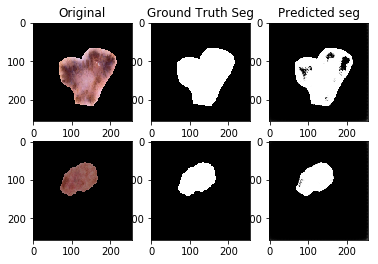

In [51]:
plt.subplot(2, 3, 1)
plt.imshow(X_test[2], cmap='gray')
plt.title('Original')

plt.subplot(2, 3, 2)
plt.imshow(y_test[2].reshape((256, 256)), cmap='gray')
plt.title('Ground Truth Seg')

plt.subplot(2, 3, 3)
plt.imshow(y_pred_test[2].reshape((256, 256)), cmap='gray')
plt.title('Predicted seg')

plt.subplot(2, 3, 4)
plt.imshow(X_test[4], cmap='gray')

plt.subplot(2, 3, 5)
plt.imshow(y_test[4].reshape((256, 256)), cmap='gray')

plt.subplot(2, 3, 6)
plt.imshow(y_pred_test[4].reshape((256, 256)), cmap='gray')



